# notebook mnist

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [17]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## MNIST data

In [18]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [19]:
nh,bs              = 50,512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )

In [20]:
mnist_view = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
#             partial(ParamScheduler, 'lr', sched),             
             partial(BatchTransformXCallback, tfm = mnist_view),
             ProgressCallback]

#layer = partial( conv_layer, stride=2, bn=False, act=GeneralRelu )
from torch import *
layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )


## mnist without kaiming initialization

In [21]:
cbfs  = cbfs_base.copy() + [LR_Finder]
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer )
learn = Learner( model, data, loss_func, opt=SGD(sched,max_lr=0.5, max_wd=0.01), cb_funcs=cbfs)
%time learn.fit(1)

CPU times: user 15.7 s, sys: 3.03 s, total: 18.7 s
Wall time: 2.87 s


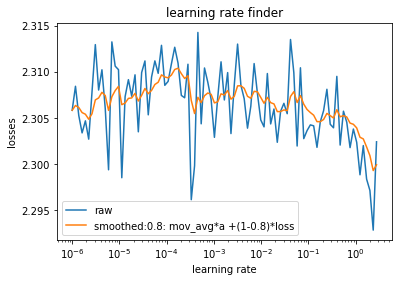

(None, None)

In [22]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,5),plt.show()
#learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [23]:
#Training: create model again because current LRFInd does not restore settings in model and opt
cbfs  = cbfs_base.copy()+[Recorder, partial(AvgStatsCallback,[accuracy])]
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer )
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
%time learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.174212,0.228340,1.072607,0.663600,00:03
1,0.679920,0.789980,0.358836,0.886800,00:03
2,0.249550,0.925620,0.180032,0.948800,00:02
3,0.181200,0.946960,0.157957,0.956900,00:02


CPU times: user 1min 5s, sys: 12.7 s, total: 1min 17s
Wall time: 11.8 s


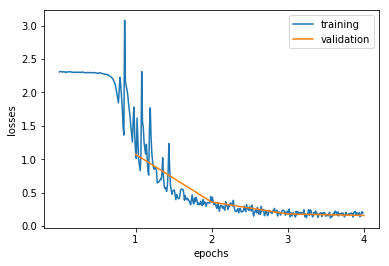

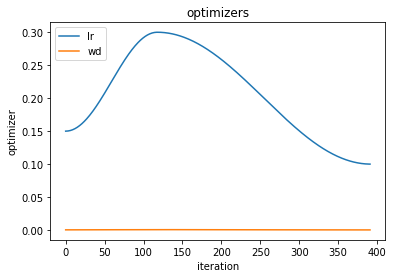

tensor(0.1668)

In [24]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [25]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view), ProgressCallback ]

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.268509,0.149840,1.723388,0.558600,00:04
1,0.843191,0.739160,0.232507,0.933800,00:03
2,0.218547,0.935200,0.147067,0.958900,00:03
3,0.130825,0.961040,0.117939,0.966500,00:03


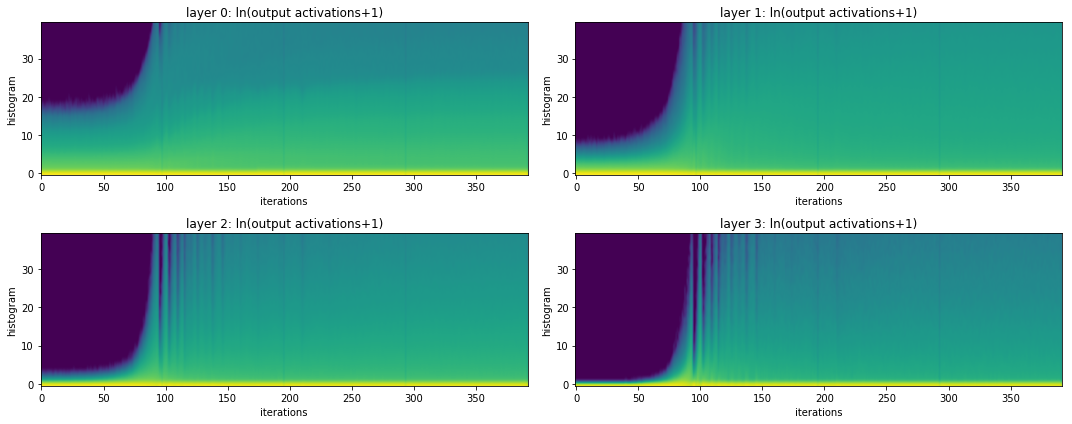

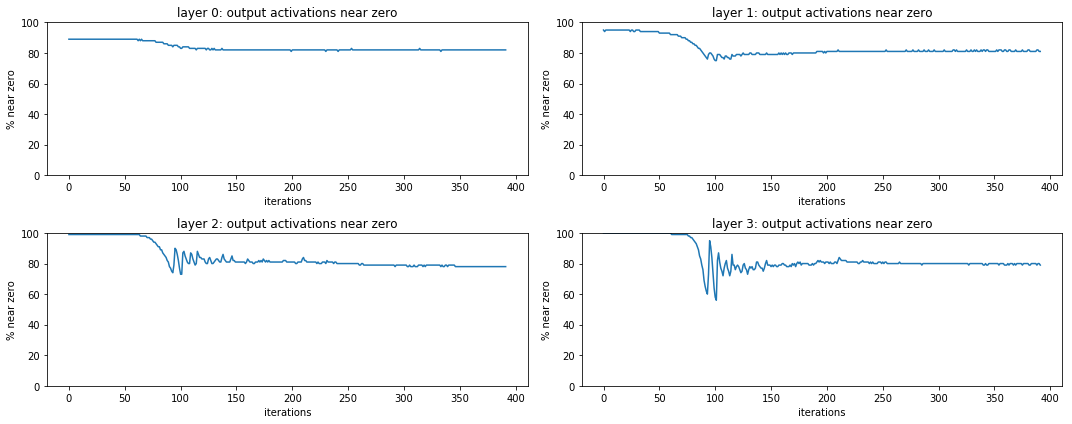

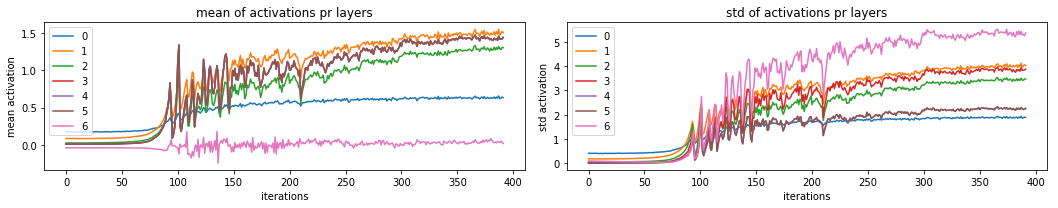

In [26]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer )
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks and kaiming initialization

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.350660,0.566280,0.496887,0.847100,00:04
1,0.354410,0.890260,0.683951,0.801000,00:04
2,0.166190,0.948380,0.111975,0.967000,00:04
3,0.102847,0.968740,0.095542,0.972000,00:03


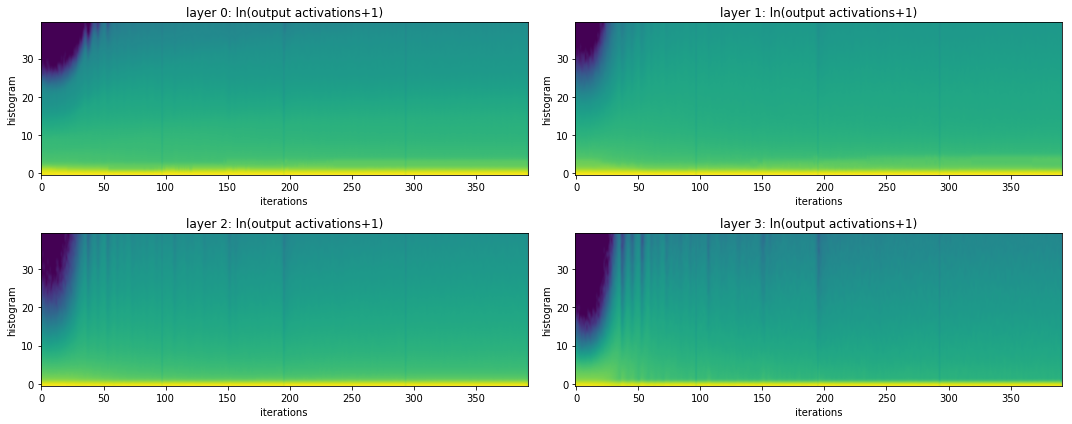

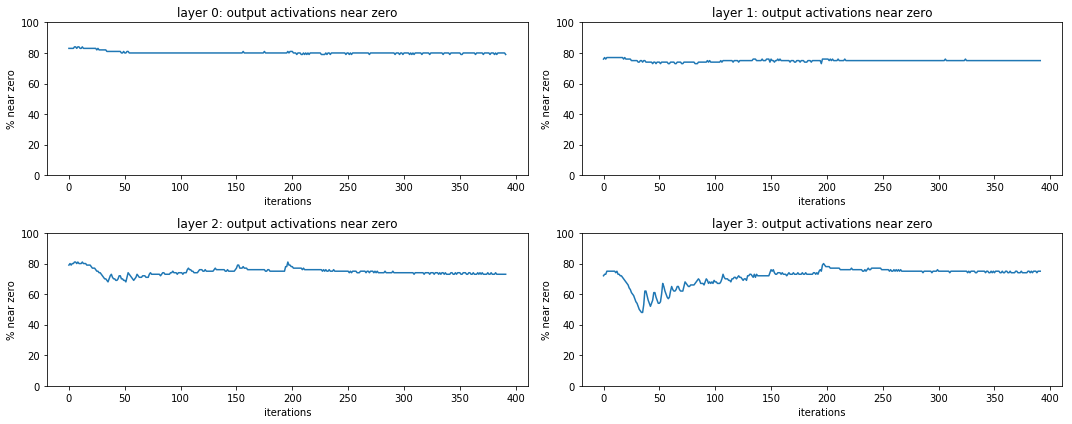

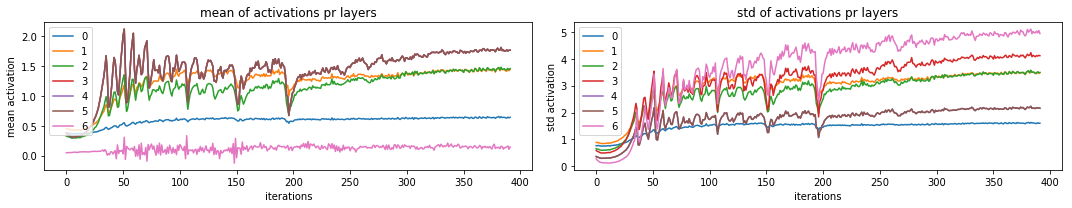

In [27]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks + kaiming initialization + batchnorm

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.586550,0.555940,0.591862,0.874400,00:06
1,0.306537,0.925540,0.155906,0.961400,00:06
2,0.131177,0.964480,0.099863,0.974800,00:05
3,0.095379,0.974360,0.088027,0.977100,00:05


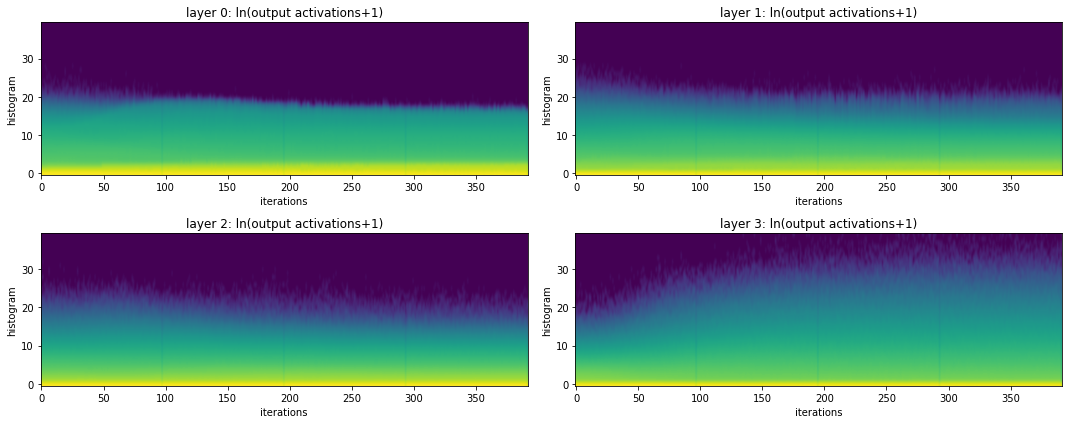

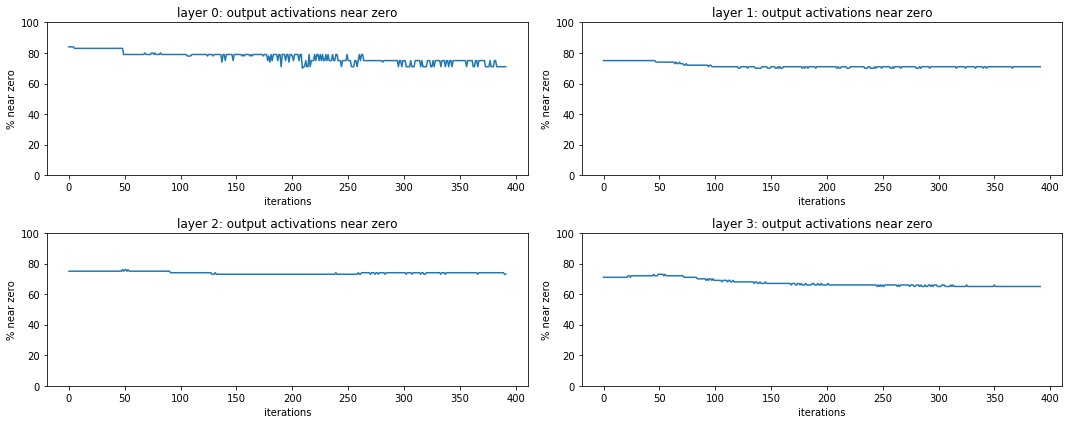

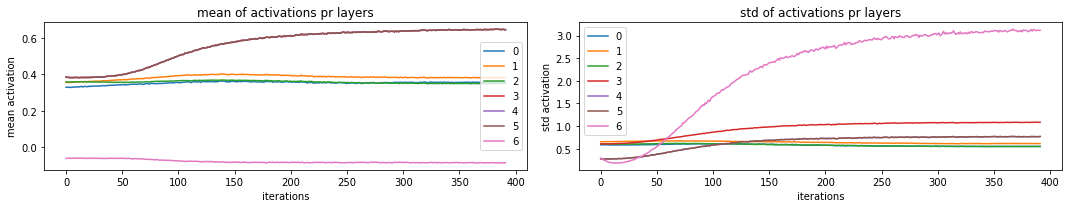

In [28]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
layer = partial( conv_layer, stride=2, bn=True, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )